In [ ]:
# Allow imports from parent directory 
import os, sys
if os.path.basename(os.getcwd()) == "notebooks":
    os.chdir("..")
    sys.path.append(os.path.abspath(".")) 
    
from astropy.io import fits
import numpy as np
import numpy as np
import pandas as pd
from scipy.ndimage import label, generate_binary_structure
import matplotlib.pyplot as plt
from astropy.coordinates import SkyCoord
import astropy.units as u
from astropy.table import Table
from tqdm import tqdm
import warnings
import pickle
from extreme_deconvolution import extreme_deconvolution
from scipy.linalg import det 
warnings.filterwarnings("ignore", category=FutureWarning)

# File path
filtered_corrected_data ='data/Allsky_Gaia_45599440_extinction_corrected_filtered.fits'

## A short investigation to determine scale of clusters
- This helps inform thresholds of clustering on known structures that we wish to indentify and how effective our filtering has been at exposing these structures
- This is how I optimised my hyperparamters

In [3]:
# Search ranges
rd_range = 0.5     # Galactic Longitude/Latitude range (degrees)
pm_range = 0.3    # Proper motion range (mas/yr)

# Define test regions (Galactic Longitude l, Latitude b, PM_RA, PM_DEC) 
regions = {
    "M3":        (042.21695, +78.70685, -0.14, -2.64),
    "NGC 1851":  (244.51323, -35.03598, 2.12, -0.63),
    "SMC":       (302.8084, -44.3277, 0.772, -1.117),
    "LMC":       (280.4652, -32.8884, 1.910, 0.229),
    "Sagitarius":(5.5682, -14.1648, -2.650, -0.880),
    "Random 1":  (0, 5, 6, 7),
    "Random 2":  (45, 0, 4, 1)
}

with fits.open(filtered_corrected_data, memmap=True) as hdul:
    data = hdul[1].data  
    l = data['l']  # Galactic longitude
    b = data['b']  # Galactic latitude
    pm_ra = data['pmra']  # Proper motion in RA
    pm_dec = data['pmdec']  # Proper motion in Dec
    summary_results = []

    # For every region
    for name, (l_c, b_c, pm_ra_c, pm_dec_c) in regions.items():
        # Determine total stars in that l and b bin (2D binning)
        mask_pos = (
            (l >= l_c - rd_range) & (l <= l_c + rd_range) &
            (b >= b_c - rd_range) & (b <= b_c + rd_range)
        )

        # Determine stars in l, b and proper motion bins (4D binning)
        mask_pos_pm = mask_pos & (
            (pm_ra >= pm_ra_c - pm_range) & (pm_ra <= pm_ra_c + pm_range) &
            (pm_dec >= pm_dec_c - pm_range) & (pm_dec <= pm_dec_c + pm_range)
        )

        # Count number of stars in each
        num_stars_pos = np.sum(mask_pos)
        num_stars_pos_pm = np.sum(mask_pos_pm)

        # Fraction of stars passing both filters
        fraction = round(num_stars_pos_pm / num_stars_pos, 3) if num_stars_pos > 0 else 0

        # Save results
        summary_results.append([name, num_stars_pos, num_stars_pos_pm, fraction])

# Display results
df_results = pd.DataFrame(summary_results, columns=["Region", "Stars (Position)", "Stars (Position + PM)", "Fraction"])
display(df_results)

,Region,Stars (Position),Stars (Position + PM),Fraction
0,M3,308,213,0.692
1,NGC 1851,145,90,0.621
2,SMC,4818,2631,0.546
3,LMC,8855,3136,0.354
4,Sagitarius,3942,101,0.026
5,Random 1,0,0,0.000
6,Random 2,0,0,0.000


# Binned Hiearchical Clustering - 4d
- Aim to indentify local structures with high densities in Position (l, b) and Proper Motion (pmra, pmdec) relative to overall ra and dec. 
- Ie areas of high concentration of proper motion
- Combine bins in a hierachical way using 4D based on adjacent bin agglomeration. 


### Initialise 4D (and 2D) bins

In [4]:
# Define bin sizes of scanning
l_b_bin_width = 1   # Galactic Longitude/Latitude bin width (±1)
pm_bin_width = 0.65  # Proper motion bin width
pm_max = 12         # Max proper motion - Gaia filter
threshold = 0.28     # Required threshold of number of stars

with fits.open(filtered_corrected_data, memmap=True) as hdul:
    data = hdul[1].data 
    l = data['l']  # Galactic longitude
    b = data['b']  # Galactic latitude
    pm_ra = data['pmra']  # Proper motion in RA
    pm_dec = data['pmdec']  # Proper motion in Dec

    # Abs b cut data based on the defined ranges
    mask = (np.abs(b) >= 10) 
    l = l[mask]
    b = b[mask]
    pm_ra = pm_ra[mask]
    pm_dec = pm_dec[mask]

# Identify bin centers -- Proper non-overlapping spacing
l_centers = np.arange(min(l) + l_b_bin_width / 2, max(l), l_b_bin_width)
b_centers = np.arange(min(b) + l_b_bin_width / 2, max(b), l_b_bin_width)
pm_ra_centers = np.arange(min(pm_ra) + pm_bin_width / 2, max(pm_ra), pm_bin_width)
pm_dec_centers = np.arange(min(pm_dec) + pm_bin_width / 2, max(pm_dec), pm_bin_width)

# Compute edges correctly from centers (proper non-overlapping bins)
l_edges = np.arange(min(l), max(l) + l_b_bin_width, l_b_bin_width)
b_edges = np.arange(min(b), max(b) + l_b_bin_width, l_b_bin_width)
pm_ra_edges = np.arange(min(pm_ra), max(pm_ra) + pm_bin_width, pm_bin_width)
pm_dec_edges = np.arange(min(pm_dec), max(pm_dec) + pm_bin_width, pm_bin_width)

# 4D Histogram: Galactic Longitude, Latitude, PM_RA, PM_DEC
hist_4d, edges_4d = np.histogramdd((l, b, pm_ra, pm_dec), bins=[l_edges, b_edges, pm_ra_edges, pm_dec_edges])

# 2D Histogram: Total sum of stars in each (l, b) bin from collapsed 4D
hist_2d = np.sum(hist_4d, axis=(2,3))

# Filter PM bins where sum is ≥ threshold% of the corresponding 2D bin
mask = (hist_4d >= threshold * hist_2d[:,:,None,None]) & (hist_4d > 20)
filtered_4d_hist = np.where(mask, hist_4d, 0)

# Total number of bins in the 4D histogram and number of non-empty bins
total_bins = filtered_4d_hist.size
nonzero_bins = np.count_nonzero(filtered_4d_hist)

# Collapse PM_RA and PM_DEC to get a 2D histogram in (l, b)
filtered_2d_hist = np.sum(filtered_4d_hist, axis=(2,3))
# Total number of (l, b) bins and non-zero bins
total_bins_2d = filtered_2d_hist.size
nonzero_bins_2d = np.count_nonzero(filtered_2d_hist)

# Print results
print(f"Total number of 4D bins: {total_bins}")
print(f"Number of nonzero 4D bins: {nonzero_bins}")
print(f"Total number of (l, b) 2D bins: {total_bins_2d}")
print(f"Number of nonzero (l, b) 2D bins: {nonzero_bins_2d}")


Total number of 4D bins: 88711200
Number of nonzero 4D bins: 325
Total number of (l, b) 2D bins: 64800
Number of nonzero (l, b) 2D bins: 277


## Investigate a rough bin population for each trial Galaxy in 2D and 4D

In [5]:
# Initialise results list
region_results = []

# Iterate over each region to find corresponding bins and star counts
for name, (l_c, b_c, pm_ra_c, pm_dec_c) in regions.items():
    # Find the closest Galactic Longitude, Latitude, PM_RA, and PM_DEC bin indices
    l_idx = np.digitize(l_c, l_edges) - 1
    b_idx = np.digitize(b_c, b_edges) - 1
    pm_ra_idx = np.digitize(pm_ra_c, pm_ra_edges) - 1
    pm_dec_idx = np.digitize(pm_dec_c, pm_dec_edges) - 1

    # Retrieve the number of stars from the filtered 4D histogram
    num_stars_2d = hist_2d[l_idx, b_idx]

    num_stars_4d = filtered_4d_hist[l_idx, b_idx, pm_ra_idx, pm_dec_idx]

    # Store results
    region_results.append([name, l_c, b_c, pm_ra_c, pm_dec_c, num_stars_2d, num_stars_4d])


# Print results in table format
print(f"{'Region':<15}{'L':<10}{'B':<10}{'PM_RA':<10}{'PM_DEC':<10}{'Stars 2D Bin':<14}{'Stars 4D Bin':<12}")
print("="*85)

for result in region_results:
    print(f"{result[0]:<15}{result[1]:<10.2f}{result[2]:<10.2f}{result[3]:<10.2f}{result[4]:<10.2f}{int(result[5]):<14}{int(result[6]):<12}")

Region         L         B         PM_RA     PM_DEC    Stars 2D Bin  Stars 4D Bin
M3             42.22     78.71     -0.14     -2.64     276           178         
NGC 1851       244.51    -35.04    2.12      -0.63     146           84          
SMC            302.81    -44.33    0.77      -1.12     5114          3121        
LMC            280.47    -32.89    1.91      0.23      7254          2389        
Sagitarius     5.57      -14.16    -2.65     -0.88     3914          0           
Random 1       0.00      5.00      6.00      7.00      0             0           
Random 2       45.00     0.00      4.00      1.00      0             0           


## Merge bins in 4 dimensions to create local structures with corrolation in all 4

In [6]:
# Cluster stars in adjacent 4D Bin
nonzero_mask = filtered_4d_hist > 0

# Define a strict 4D connectivity structure (ensuring adjacency in all 4D dimensions)
structure = generate_binary_structure(rank=4, connectivity=1)

# Apply labeling to identify distinct clusters
labeled_array, num_features = label(nonzero_mask, structure=structure)

# Store cluster Galactic Longitude, Latitude, and Proper Motion ranges
cluster_ranges = []

# Loop through each cluster ID
for i in range(1, num_features + 1):  # Cluster labels start from 1
    indices = np.argwhere(labeled_array == i)  # Get all (L, B, PM_RA, PM_DEC) indices for cluster

    # Extract corresponding Galactic Longitude and Latitude bin edges
    l_min = l_edges[min(indices[:, 0])]  # Min L bin edge
    l_max = l_edges[max(indices[:, 0]) + 1]  # Max L bin edge (next bin's start)
    b_min = b_edges[min(indices[:, 1])]  # Min B bin edge
    b_max = b_edges[max(indices[:, 1]) + 1]  # Max B bin edge (next bin's start)

    # Extract corresponding Proper Motion bin edges
    pm_ra_min = pm_ra_edges[min(indices[:, 2])]  # Min PM_RA bin edge
    pm_ra_max = pm_ra_edges[max(indices[:, 2]) + 1]  # Max PM_RA bin edge (next bin's start)
    pm_dec_min = pm_dec_edges[min(indices[:, 3])]  # Min PM_DEC bin edge
    pm_dec_max = pm_dec_edges[max(indices[:, 3]) + 1]  # Max PM_DEC bin edge (next bin's start)

    # Store results
    cluster_ranges.append([i, l_min, l_max, b_min, b_max, pm_ra_min, pm_ra_max, pm_dec_min, pm_dec_max])

## Remove nested clusters that haven't merged 
- These exist as they are sit in a 4D structure without being connected
- Ie within the web but not touching

In [7]:
# Identify clusters that are fully contained within another cluster
clusters_to_remove = set()

for i, cluster_outer in enumerate(cluster_ranges):
    cluster_id_outer, l_min_outer, l_max_outer, b_min_outer, b_max_outer, pm_ra_min_outer, pm_ra_max_outer, pm_dec_min_outer, pm_dec_max_outer = cluster_outer

    for j, cluster_inner in enumerate(cluster_ranges):
        if i == j:  # Skip self-comparison
            continue

        cluster_id_inner, l_min_inner, l_max_inner, b_min_inner, b_max_inner, pm_ra_min_inner, pm_ra_max_inner, pm_dec_min_inner, pm_dec_max_inner = cluster_inner

        # Check if inner cluster is fully contained within outer cluster
        if (l_min_outer <= l_min_inner <= l_max_inner <= l_max_outer) and \
           (b_min_outer <= b_min_inner <= b_max_inner <= b_max_outer) and \
           (pm_ra_min_outer <= pm_ra_min_inner <= pm_ra_max_inner <= pm_ra_max_outer) and \
           (pm_dec_min_outer <= pm_dec_min_inner <= pm_dec_max_inner <= pm_dec_max_outer):
            clusters_to_remove.add(j)  # Mark the inner cluster for removal

# Remove fully contained clusters
cluster_ranges = [cluster for i, cluster in enumerate(cluster_ranges) if i not in clusters_to_remove]

# Print the number of removed clusters
print(f"Removed {len(clusters_to_remove)} fully contained clusters.")

Removed 1 fully contained clusters.


## Load Data Bases of Known Substructures
- `Vasilev et al. 2019` - Positions and Proper Motions of Globuluar Clusters
- `Drlica-Wagner et al. 2020` - Local Dwarf Galaxies and sub structures

In [8]:
# This is used for cross-matching with the Gaia dataset
PMGC_path = 'data/PMGC_vasiliev2019.fit'
with fits.open(PMGC_path) as PMGC_hdul:
    PMGC_data = Table(PMGC_hdul[1].data).to_pandas()

# Convert RA/Dec to Galactic coordinates (l, b)
sky_coords = SkyCoord(ra=PMGC_data['RAJ2000'].values * u.degree, 
                      dec=PMGC_data['DEJ2000'].values * u.degree, 
                      frame='icrs')
galactic_coords = sky_coords.galactic
PMGC_data['l'] = galactic_coords.l.deg
PMGC_data['b'] = galactic_coords.b.deg


# Load the data from Milky Way Satellites Census - (Drlica-Wagner et al. 2020)
MWC_path = 'data/MWCens_DW2020.fit'
with fits.open(MWC_path) as MWC_hdul:
    MWC_data = Table(MWC_hdul[1].data).to_pandas()

# Convert RA/Dec to Galactic coordinates (l, b)
sky_coords = SkyCoord(ra=MWC_data['RAJ2000'].values * u.degree, 
                      dec=MWC_data['DEJ2000'].values * u.degree, 
                      frame='icrs')
galactic_coords = sky_coords.galactic
MWC_data['l'] = galactic_coords.l.deg
MWC_data['b'] = galactic_coords.b.deg


## Store Boundaries of Merged Stellar Halos - 4d HyperCube
- Determine whether any known substructures fall within these boundaries
- If proper motion is available uses 4D boundaries 
- If not used 2D Boundaries

In [9]:
# Dictionary to store matched clusters and their true values
matched_clusters_dict = {cluster[0]: [] for cluster in cluster_ranges}
cluster_true_values = {
    cluster[0]: {"l": [], "b": [], "pm_ra": [], "pm_dec": [], "source": []} 
    for cluster in cluster_ranges
}

# Function to process each dataset (handles missing proper motion)
def match_objects(data, source_label, has_proper_motion=True):
    for index, row in data.iterrows():
        l_obj, b_obj, name = row['l'], row['b'], row['Name']
        
        if has_proper_motion:
            pm_ra_obj, pm_dec_obj = row['pmRA'], row['pmDE']
        else:
            pm_ra_obj, pm_dec_obj = None, None  # Set to None if missing

        for cluster in cluster_ranges:
            cluster_id, l_min, l_max, b_min, b_max, pm_ra_min, pm_ra_max, pm_dec_min, pm_dec_max = cluster
            
            # Check if the object falls inside the cluster range
            if (l_min <= l_obj <= l_max) and (b_min <= b_obj <= b_max):
                # If proper motion is available, check those constraints too
                if has_proper_motion:
                    if not (pm_ra_min <= pm_ra_obj <= pm_ra_max) or not (pm_dec_min <= pm_dec_obj <= pm_dec_max):
                        continue  # Skip if proper motion doesn't match
                
                # Store matches with source label
                matched_clusters_dict[cluster_id].append(name)
                cluster_true_values[cluster_id]["l"].append(l_obj)
                cluster_true_values[cluster_id]["b"].append(b_obj)
                cluster_true_values[cluster_id]["source"].append(source_label)  # Add source label
                if has_proper_motion:
                    cluster_true_values[cluster_id]["pm_ra"].append(pm_ra_obj)
                    cluster_true_values[cluster_id]["pm_dec"].append(pm_dec_obj)

# Match objects in PMGC (which has proper motion data)
match_objects(PMGC_data, source_label="PMGC", has_proper_motion=True)

# Match objects in MWC (which does NOT have proper motion data)
match_objects(MWC_data, source_label="MWC", has_proper_motion=False)

# Convert matched clusters into a structured list for printing and plotting
matched_clusters = [
    [cluster_id, ", ".join(matched_clusters_dict[cluster_id]) if matched_clusters_dict[cluster_id] else "N/A"]
    for cluster_id in matched_clusters_dict
]

# Count the number of matched clusters (clusters that have at least one match)
num_matched_clusters = sum(1 for cluster_id in matched_clusters_dict if matched_clusters_dict[cluster_id])

# Print total clusters found
print(f"Total distinct clusters found: {len(cluster_ranges)}")
print(f"Total number of matched clusters: {num_matched_clusters}")

Total distinct clusters found: 19
Total number of matched clusters: 19


## Print Clusters Found and Matching Structures

In [10]:
# Print results in table format
print(f"{'Cluster':<15}{'L Min':<15}{'L Max':<15}{'L True':<15}{'B Min':<15}{'B Max':<15}{'B True':<15}"
      f"{'PM_RA Min':<15}{'PM_RA Max':<15}{'PM_RA True':<15}{'PM_DEC Min':<15}{'PM_DEC Max':<15}{'PM_DEC True':<15}{'PMGC Name':<15}")
print("=" * 215)

for cluster in cluster_ranges:
    cluster_id, l_min, l_max, b_min, b_max, pm_ra_min, pm_ra_max, pm_dec_min, pm_dec_max = cluster
    matched_names = ", ".join(matched_clusters_dict[cluster_id]) if matched_clusters_dict[cluster_id] else "N/A"

    l_true = ", ".join(f"{val:.2f}" for val in cluster_true_values[cluster_id]["l"]) if cluster_true_values[cluster_id]["l"] else "N/A"
    b_true = ", ".join(f"{val:.2f}" for val in cluster_true_values[cluster_id]["b"]) if cluster_true_values[cluster_id]["b"] else "N/A"
    pm_ra_true = ", ".join(f"{val:.2f}" for val in cluster_true_values[cluster_id]["pm_ra"]) if cluster_true_values[cluster_id]["pm_ra"] else "N/A"
    pm_dec_true = ", ".join(f"{val:.2f}" for val in cluster_true_values[cluster_id]["pm_dec"]) if cluster_true_values[cluster_id]["pm_dec"] else "N/A"

    print(f"{cluster_id:<15}{l_min:<15.2f}{l_max:<15.2f}{l_true:<15}{b_min:<15.2f}{b_max:<15.2f}{b_true:<15}"
          f"{pm_ra_min:<15.2f}{pm_ra_max:<15.2f}{pm_ra_true:<15}{pm_dec_min:<15.2f}{pm_dec_max:<15.2f}{pm_dec_true:<15}{matched_names:<15}")

Cluster        L Min          L Max          L True         B Min          B Max          B True         PM_RA Min      PM_RA Max      PM_RA True     PM_DEC Min     PM_DEC Max     PM_DEC True    PMGC Name      
1              3.00           5.00           3.86           46.27          47.27          46.80          3.60           4.25           4.08           -10.05         -9.40          -9.85          NGC 5904       
2              27.00          28.00          27.18          -47.73         -46.73         -46.84         -0.95          -0.30          -0.69          -7.45          -6.80          -7.27          NGC 7099       
3              35.00          36.00          35.16          -32.73         -31.73         -32.68         -1.60          -0.95          -1.23          -3.55          -2.90          -3.29          NGC 6981       
4              41.00          43.00          42.22          78.27          79.27          78.71          -0.30          0.35           -0.14          -2.90 

## Display Structures

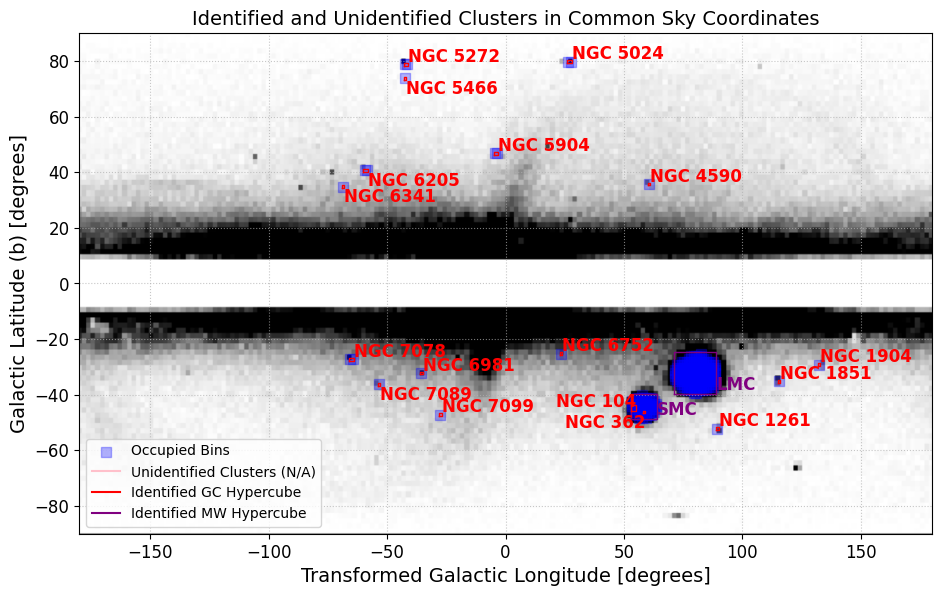

In [16]:
# Function to transform Galactic Longitude (l) to common sky coordinates
def transform_l(l_values):
    transformed = - l_values  
    transformed = (transformed + 180) % 360 - 180  # Wrap to [-180, 180] range
    return transformed

# Identify occupied L-B bins from filtered 2D histogram
occupied_l_b = np.argwhere(filtered_2d_hist > 0)

# Convert indices to Galactic Longitude (L) and Latitude (B) centers
l_occupied = transform_l(l_centers[occupied_l_b[:, 0]])  # Apply transformation
b_occupied = b_centers[occupied_l_b[:, 1]]  # Latitude remains the same

# Create a scatter plot of occupied bins
plt.figure(figsize=(11, 6.5))
plt.xlim(-180, 180)
plt.ylim(-90, 90)


### --- Background ----
bg_image = plt.imread("backgroundimage/background.png")

plt.imshow(bg_image,
           extent=[-180, 180, -90, 90],  
           aspect='auto',
           alpha=1,             
           zorder=0)  


plt.scatter(l_occupied, b_occupied, marker='s', s=50, alpha=0.3, label="Occupied Bins", color='blue')

matched_dict = {match[0]: match[1] for match in matched_clusters} 

# Add boxes for clusters
for cluster in cluster_ranges:
    cluster_id, l_min, l_max, b_min, b_max = cluster[:5]  

    # Transform l_min and l_max
    l_min_transformed = transform_l(l_min)
    l_max_transformed = transform_l(l_max)

    # Rearrange for correct ordering for box plotting 
    if l_min_transformed > l_max_transformed:
        l_min_transformed, l_max_transformed = l_max_transformed, l_min_transformed

    # Check if the cluster is identified (has a name) or unidentified (N/A)
    name = matched_dict.get(cluster_id, "N/A")

    # Determine the cluster source (PMGC or MWC)
    # If multiple sources, choose the first one
    source = None
    for i in range(len(cluster_true_values[cluster_id]["source"])):
        source = cluster_true_values[cluster_id]["source"][i]  
        break

    # Assign colors based on source
    if source == "PMGC":
        color = 'red'  # Glob Clust in red
    elif source == "MWC":
        color = 'purple'  # Dwarf Galaxy in purple
    else:
        color = 'blue'  # Blue for unidentified clusters

    # Draw the cluster box with transformed l values
    plt.plot(
        [l_min_transformed, l_max_transformed, l_max_transformed, l_min_transformed, l_min_transformed],
        [b_min, b_min, b_max, b_max, b_min],
        linestyle='-', color=color, linewidth=1
    )

    # Text formatting for identified clusters
    # If matched, add the PMGC name as text inside the box
    if name in ['NGC 5053', 'NGC 5466', 'NGC 6341', 'NGC 7089', 'NGC 6205']:
        plt.text(l_max_transformed, b_min, name, fontsize=12, color=color, ha='left', va='top', fontweight='bold')
    elif name in ['Sagittarius', 'NGC 5286', 'NGC 104', 'NGC 2419']:
        plt.text(l_max_transformed, b_min, name, fontsize=12, color=color, ha='right', va='bottom', fontweight='bold')
    elif name in ['NGC 362']:
        plt.text(l_max_transformed, b_min, name, fontsize=12, color=color, ha='right', va='top', fontweight='bold')
    # Formating of Teran'
    elif name[0] == 'T':
        plt.text(l_max_transformed, b_min, name[:9] + "\n" + name[10:16] + "\n"+ name[17:25], fontsize=12, color='red', ha='left', va='top', fontweight='bold')
    elif name != "N/A":
        plt.text(l_max_transformed, b_min, name, fontsize=12, color=color, ha='left', va='bottom', fontweight='bold')


# Labels and formatting
plt.xlabel("Transformed Galactic Longitude [degrees]", fontsize=14)
plt.ylabel("Galactic Latitude (b) [degrees]", fontsize=14)
plt.title("Identified and Unidentified Clusters in Common Sky Coordinates", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.plot([], [], color = 'pink', label="Unidentified Clusters (N/A)")
plt.plot([], [], 'r-', label="Identified GC Hypercube")
plt.plot([], [], 'purple', label="Identified MW Hypercube")
plt.legend(fontsize=10, loc="lower left")

plt.grid(True, linestyle=":", alpha=0.7)  
plt.show()

In [12]:
import json
with fits.open(filtered_corrected_data, memmap=True) as hdul:
    data = hdul[1].data
    star_ids = data['source_id']
    l_values = data['l']  # Galactic longitude
    b_values = data['b']  # Galactic latitude
    pm_ra_values = data['pmra']  # Proper motion in RA
    pm_dec_values = data['pmdec']  # Proper motion in Dec

# Convert FITS data into a structured NumPy array for faster querying
gaia_data = np.array(list(zip(star_ids, l_values, b_values, pm_ra_values, pm_dec_values)),
                     dtype=[('source_id', 'i8'), ('l', 'f8'), ('b', 'f8'), ('pmra', 'f8'), ('pmdec', 'f8')])

# Dictionary to store matched clusters with Gaia star IDs
matched_clusters_dict = {}

# Iterate over detected clusters and find matching Gaia stars
for cluster in cluster_ranges:
    cluster_id, l_min, l_max, b_min, b_max, pm_ra_min, pm_ra_max, pm_dec_min, pm_dec_max = cluster
    matched_names = ", ".join(matched_dict.get(cluster_id, []) if isinstance(matched_dict.get(cluster_id, []), list) else [matched_dict.get(cluster_id, "")])
    if matched_names == "N/A":
        continue

    # Find Gaia stars within the given L, B, PM_RA, and PM_DEC ranges
    if matched_names:
        mask = (
            (gaia_data['l'] >= l_min) & (gaia_data['l'] <= l_max) &
            (gaia_data['b'] >= b_min) & (gaia_data['b'] <= b_max) &
            (gaia_data['pmra'] >= pm_ra_min) & (gaia_data['pmra'] <= pm_ra_max) &
            (gaia_data['pmdec'] >= pm_dec_min) & (gaia_data['pmdec'] <= pm_dec_max)
        )

        matched_stars = gaia_data[mask]

        print(f"Cluster: {matched_names}, Stars: {len(matched_stars)}")

        # If no matching stars, skip storing this cluster
        if len(matched_stars) == 0:
            continue

        # Store matched cluster details
        matched_clusters_dict[matched_names] = {
            "l_min": l_min,
            "l_max": l_max,
            "b_min": b_min,
            "b_max": b_max,
            "gaia_source_ids": matched_stars['source_id'].tolist()  # Store Gaia Star IDs
        }

# Save dictionary as a JSON file
output_file = "data/matched_clusters_HigherPM.json"
with open(output_file, "w") as f:
    json.dump(matched_clusters_dict, f, indent=4)

print(f"Saved matched clusters with Gaia IDs to: {output_file}")

Cluster: NGC 5904, Stars: 332
Cluster: NGC 7099, Stars: 100
Cluster: NGC 6981, Stars: 39
Cluster: NGC 5272, Stars: 235
Cluster: NGC 5466, Stars: 29
Cluster: NGC 7089, Stars: 56
Cluster: NGC 6205, Stars: 412
Cluster: NGC 7078, Stars: 183
Cluster: NGC 6341, Stars: 156
Cluster: NGC 1904, Stars: 28
Cluster: NGC 1851, Stars: 84
Cluster: NGC 1261, Stars: 31
Cluster: LMC, Stars: 200825
Cluster: SMC, Stars: 27054
Cluster: NGC 4590, Stars: 69
Cluster: NGC 362, Stars: 184
Cluster: NGC 104, Stars: 1095
Cluster: NGC 5024, Stars: 72
Cluster: NGC 6752, Stars: 518
Saved matched clusters with Gaia IDs to: data/matched_clusters_HigherPM.json
